In [1]:
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import time
import os
from IPython import display
from keras import backend
from keras.constraints import Constraint

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_x = loadmat('/content/drive/MyDrive/AML - john & samory/train_32x32.mat')['X']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_x.shape

(32, 32, 3, 73257)

In [4]:
#We need to get the number of images as the first dimension
train_x=train_x.transpose((3,0,1,2))
train_x.shape

(73257, 32, 32, 3)

In [5]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
noise_dim = 100
num_examples_to_generate = 16

In [6]:
# from github - removed if else statement since we have all 32X32 images (made another function later for else part)
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        ax.imshow(img[i])


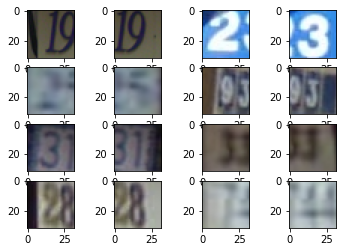

In [7]:
plot_images(train_x, 4, 4)

To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process.

Y = 0.2990R + 0.5870G + 0.1140B

Here is a simple function that helps us print the size of a numpy array in a human readable format.

In [10]:
train_x = tf.image.rgb_to_grayscale(tf.convert_to_tensor(train_x)).numpy().astype(np.float32)

In [11]:
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        ax.imshow(img[i,:,:,0])

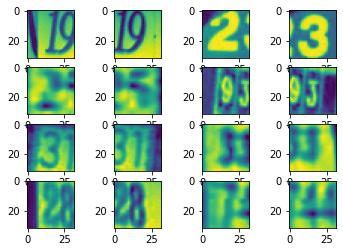

In [12]:
plot_images(train_x, 4, 4)

In [13]:
train_x = (train_x - 127.5) / 127.5 
#test_x = (test_x - 127.5) / 127.5

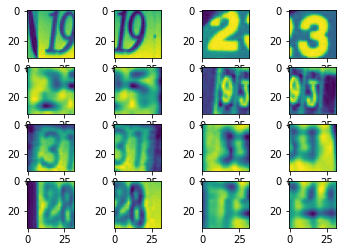

In [14]:
plot_images(train_x, 4, 4)

In [15]:
train_x = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#test_x = tf.data.Dataset.from_tensor_slices(test_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
def discriminator_loss(real_output, fake_output):
    
    real_loss = real_output
    fake_loss = fake_output
    total_loss = -tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    return total_loss


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [19]:
#from tutorial
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [20]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00005)

In [21]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# from tutorial
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

In [24]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if (epoch==1) or (epoch%10==0):
    plt.savefig('/content/drive/MyDrive/AML - john & samory/'+model_+'_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

  

In [25]:
# from tutorial 
def train(dataset, epochs, generator, discriminator):

  for epoch in range(epochs):
    start = time.time()

    # train
    loss_train = []
    for image_batch in dataset:
      loss_train.append(train_step(image_batch, generator, discriminator))

    train_loss.loc[len(train_loss)] = np.mean(loss_train, axis=0)

    # tensorboard
    with gen_summary_writer.as_default():
        tf.summary.scalar('generator_loss', train_loss.gen_loss.values[-1], step=epoch)
    with disc_summary_writer.as_default():
        tf.summary.scalar('discrinimator_loss', train_loss.disc_loss.values[-1], step=epoch)

    # Produce images for the GIF as we go
    if (epoch==1) or (epoch%10==0):
        generate_and_save_images(generator,
                             epoch,
                             seed)
    
    print('Time for epoch {} is {} sec, generation loss: {}, discrimination loss: {}'.format(epoch + 1, time.time()-start, train_loss.gen_loss.values[-1], train_loss.disc_loss.values[-1]))

  # Generate after the final epoch
  
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  return 
  



In [26]:
# from github - added function
def summary_writer(dir):
    return(tf.summary.create_file_writer(dir))


In [27]:
%reload_ext tensorboard

In [28]:
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [29]:
def make_generator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, use_bias=False, input_shape=(100,), activation='relu'))
    model.add(layers.Dense(512, use_bias=False, activation='relu'))
    model.add(layers.Dense(4096, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), use_bias=False, activation='tanh'))



    return model

In [30]:
def make_discriminator_model_2():
    const = ClipConstraint(0.01)
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(1, 1),kernel_constraint=const, padding='same', use_bias=False, input_shape=[32, 32, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))


    model.add(layers.Conv2D(128, (4, 4), strides=(1, 1),padding='same', kernel_constraint=const, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))


    model.add(layers.Conv2D(256, (4, 4), strides=(1, 1),kernel_constraint=const, use_bias=False,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, kernel_constraint=const, use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(64,kernel_constraint=const, use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(16,kernel_constraint=const, use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1))

    return model

In [31]:
generator_2 = make_generator_model_2()
discriminator_2 = make_discriminator_model_2()

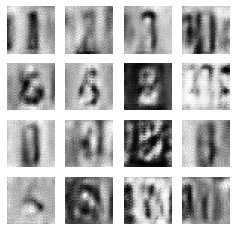

Time for epoch 1 is 44.27104663848877 sec, generation loss: -14.30005168914795, discrimination loss: 6.698383331298828


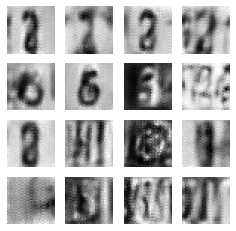

Time for epoch 2 is 36.92391896247864 sec, generation loss: -25.442119598388672, discrimination loss: 12.879693984985352
Time for epoch 3 is 35.27360510826111 sec, generation loss: -30.498828887939453, discrimination loss: 15.87563419342041
Time for epoch 4 is 35.53609561920166 sec, generation loss: -33.441307067871094, discrimination loss: 17.968223571777344
Time for epoch 5 is 35.54362440109253 sec, generation loss: -35.546897888183594, discrimination loss: 19.79511833190918
Time for epoch 6 is 35.44033885002136 sec, generation loss: -36.32851791381836, discrimination loss: 20.67102813720703
Time for epoch 7 is 35.50441789627075 sec, generation loss: -37.37163162231445, discrimination loss: 22.0465145111084
Time for epoch 8 is 35.696333169937134 sec, generation loss: -37.80361557006836, discrimination loss: 22.69256591796875
Time for epoch 9 is 35.538777112960815 sec, generation loss: -38.766578674316406, discrimination loss: 24.301170349121094
Time for epoch 10 is 35.64513564109802 

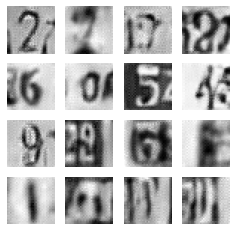

Time for epoch 11 is 36.50430607795715 sec, generation loss: -39.374507904052734, discrimination loss: 26.155609130859375
Time for epoch 12 is 35.552748918533325 sec, generation loss: -40.567535400390625, discrimination loss: 28.003192901611328
Time for epoch 13 is 35.540860414505005 sec, generation loss: -41.43242263793945, discrimination loss: 29.945377349853516
Time for epoch 14 is 35.56223106384277 sec, generation loss: -42.081722259521484, discrimination loss: 30.22234535217285
Time for epoch 15 is 35.456300020217896 sec, generation loss: -43.035430908203125, discrimination loss: 30.925819396972656
Time for epoch 16 is 35.62730145454407 sec, generation loss: -43.578773498535156, discrimination loss: 32.61872482299805
Time for epoch 17 is 35.60973834991455 sec, generation loss: -43.98594665527344, discrimination loss: 32.55677032470703
Time for epoch 18 is 35.54075574874878 sec, generation loss: -43.87377166748047, discrimination loss: 33.27895736694336
Time for epoch 19 is 35.6305

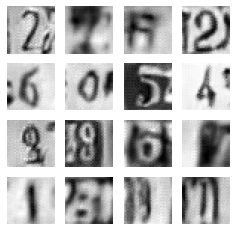

Time for epoch 21 is 36.561394453048706 sec, generation loss: -46.23188018798828, discrimination loss: 40.947967529296875
Time for epoch 22 is 35.64959502220154 sec, generation loss: -44.96672058105469, discrimination loss: 35.294151306152344
Time for epoch 23 is 35.70868372917175 sec, generation loss: -45.635223388671875, discrimination loss: 39.78461456298828
Time for epoch 24 is 35.67295026779175 sec, generation loss: -47.14722442626953, discrimination loss: 38.47462844848633
Time for epoch 25 is 35.67589616775513 sec, generation loss: -47.65016174316406, discrimination loss: 40.75517272949219
Time for epoch 26 is 35.61717891693115 sec, generation loss: -48.65443420410156, discrimination loss: 42.3672981262207
Time for epoch 27 is 35.589351177215576 sec, generation loss: -47.639991760253906, discrimination loss: 39.32481002807617
Time for epoch 28 is 35.60682940483093 sec, generation loss: -48.37211608886719, discrimination loss: 41.95014953613281
Time for epoch 29 is 35.51672601699

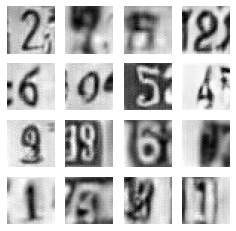

Time for epoch 31 is 36.5106885433197 sec, generation loss: -49.855079650878906, discrimination loss: 45.55563735961914
Time for epoch 32 is 35.561185121536255 sec, generation loss: -50.563453674316406, discrimination loss: 46.42029571533203
Time for epoch 33 is 35.710214138031006 sec, generation loss: -50.204627990722656, discrimination loss: 46.28072738647461
Time for epoch 34 is 35.59442162513733 sec, generation loss: -51.51145553588867, discrimination loss: 41.97290802001953
Time for epoch 35 is 35.52530360221863 sec, generation loss: -50.79770278930664, discrimination loss: 47.06034851074219
Time for epoch 36 is 35.46831011772156 sec, generation loss: -53.07099151611328, discrimination loss: 49.51473617553711
Time for epoch 37 is 35.46383213996887 sec, generation loss: -53.07160568237305, discrimination loss: 55.77290725708008
Time for epoch 38 is 35.60499453544617 sec, generation loss: -51.782535552978516, discrimination loss: 50.135066986083984
Time for epoch 39 is 35.6381251811

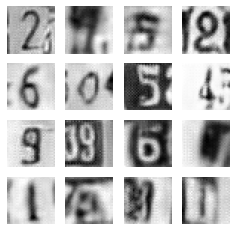

Time for epoch 41 is 36.4814887046814 sec, generation loss: -53.89569091796875, discrimination loss: 54.80010223388672
Time for epoch 42 is 35.57036542892456 sec, generation loss: -53.43207931518555, discrimination loss: 55.91252899169922
Time for epoch 43 is 35.621426820755005 sec, generation loss: -54.430206298828125, discrimination loss: 60.06153869628906
Time for epoch 44 is 35.676554441452026 sec, generation loss: -52.58302688598633, discrimination loss: 46.11513900756836
Time for epoch 45 is 35.63145565986633 sec, generation loss: -54.39716339111328, discrimination loss: 64.81814575195312
Time for epoch 46 is 35.5815954208374 sec, generation loss: -54.01432418823242, discrimination loss: 50.993900299072266
Time for epoch 47 is 35.68584990501404 sec, generation loss: -55.442806243896484, discrimination loss: 56.92095184326172
Time for epoch 48 is 35.74696731567383 sec, generation loss: -55.49116897583008, discrimination loss: 62.404293060302734
Time for epoch 49 is 35.669646501541

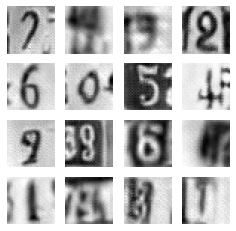

Time for epoch 51 is 36.6288537979126 sec, generation loss: -56.846805572509766, discrimination loss: 75.49327087402344
Time for epoch 52 is 35.62254619598389 sec, generation loss: -56.70989990234375, discrimination loss: 67.74014282226562
Time for epoch 53 is 35.53951811790466 sec, generation loss: -58.64335250854492, discrimination loss: 64.01578521728516
Time for epoch 54 is 35.63388156890869 sec, generation loss: -59.421730041503906, discrimination loss: 64.52430725097656
Time for epoch 55 is 35.63002586364746 sec, generation loss: -57.68244934082031, discrimination loss: 67.12339782714844
Time for epoch 56 is 35.6813702583313 sec, generation loss: -59.83151626586914, discrimination loss: 70.56379699707031
Time for epoch 57 is 35.62262320518494 sec, generation loss: -60.18696594238281, discrimination loss: 63.537841796875
Time for epoch 58 is 35.603132486343384 sec, generation loss: -55.61094665527344, discrimination loss: 55.57175064086914
Time for epoch 59 is 35.69759202003479 se

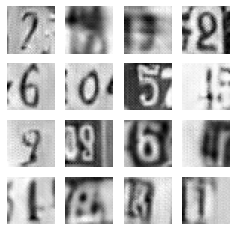

Time for epoch 61 is 36.75582504272461 sec, generation loss: -59.58076477050781, discrimination loss: 60.143375396728516
Time for epoch 62 is 35.61002779006958 sec, generation loss: -61.552669525146484, discrimination loss: 59.54210662841797
Time for epoch 63 is 35.64887452125549 sec, generation loss: -61.191627502441406, discrimination loss: 64.04668426513672
Time for epoch 64 is 35.661057233810425 sec, generation loss: -66.02645874023438, discrimination loss: 59.6711311340332
Time for epoch 65 is 35.576714277267456 sec, generation loss: -61.66938400268555, discrimination loss: 40.69435501098633
Time for epoch 66 is 35.63624358177185 sec, generation loss: -65.57096862792969, discrimination loss: 59.979217529296875
Time for epoch 67 is 35.60901975631714 sec, generation loss: -64.2613296508789, discrimination loss: 32.11071014404297
Time for epoch 68 is 35.66881728172302 sec, generation loss: -64.45933532714844, discrimination loss: 51.99712371826172
Time for epoch 69 is 35.670217990875

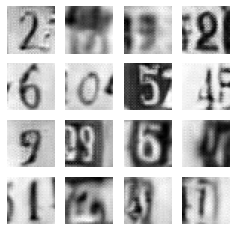

Time for epoch 71 is 36.73266410827637 sec, generation loss: -65.21865844726562, discrimination loss: 58.742431640625
Time for epoch 72 is 35.616539001464844 sec, generation loss: -65.71981811523438, discrimination loss: 41.29503631591797
Time for epoch 73 is 35.64315676689148 sec, generation loss: -69.58445739746094, discrimination loss: 37.87139129638672
Time for epoch 74 is 35.5785174369812 sec, generation loss: -68.85044860839844, discrimination loss: 51.792659759521484
Time for epoch 75 is 35.68937849998474 sec, generation loss: -67.48757934570312, discrimination loss: 38.91887283325195
Time for epoch 76 is 35.68656134605408 sec, generation loss: -66.93651580810547, discrimination loss: 31.8211727142334
Time for epoch 77 is 35.65596103668213 sec, generation loss: -68.11296081542969, discrimination loss: 57.438011169433594
Time for epoch 78 is 35.69277238845825 sec, generation loss: -69.32816314697266, discrimination loss: 53.24617385864258
Time for epoch 79 is 35.59101843833923 se

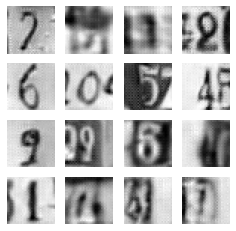

Time for epoch 81 is 36.451650857925415 sec, generation loss: -67.32389831542969, discrimination loss: 55.345638275146484
Time for epoch 82 is 35.52687406539917 sec, generation loss: -72.61548614501953, discrimination loss: 63.02381134033203
Time for epoch 83 is 35.622236013412476 sec, generation loss: -68.02542114257812, discrimination loss: 59.27085876464844
Time for epoch 84 is 35.5999801158905 sec, generation loss: -72.30599212646484, discrimination loss: 56.186973571777344
Time for epoch 85 is 35.60840106010437 sec, generation loss: -65.58917236328125, discrimination loss: 41.048683166503906
Time for epoch 86 is 35.667969942092896 sec, generation loss: -70.90440368652344, discrimination loss: 62.429283142089844
Time for epoch 87 is 35.66165471076965 sec, generation loss: -75.70519256591797, discrimination loss: 77.57936096191406
Time for epoch 88 is 35.767725706100464 sec, generation loss: -75.14274597167969, discrimination loss: 74.06729125976562
Time for epoch 89 is 35.546227455

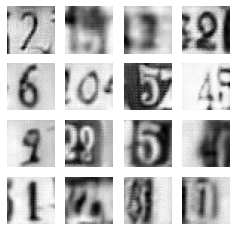

Time for epoch 91 is 36.73997497558594 sec, generation loss: -67.23838806152344, discrimination loss: 42.401405334472656
Time for epoch 92 is 35.582123041152954 sec, generation loss: -67.15351867675781, discrimination loss: 27.948816299438477
Time for epoch 93 is 35.670231103897095 sec, generation loss: -67.52288818359375, discrimination loss: 41.48664474487305
Time for epoch 94 is 35.68327760696411 sec, generation loss: -69.18651580810547, discrimination loss: 53.84019088745117
Time for epoch 95 is 35.57168126106262 sec, generation loss: -70.39313507080078, discrimination loss: 50.18311309814453
Time for epoch 96 is 35.55719041824341 sec, generation loss: -69.12245178222656, discrimination loss: 44.677757263183594
Time for epoch 97 is 35.512001514434814 sec, generation loss: -66.34209442138672, discrimination loss: 53.43248748779297
Time for epoch 98 is 35.48732948303223 sec, generation loss: -70.09410095214844, discrimination loss: 71.88304138183594
Time for epoch 99 is 35.5448670387

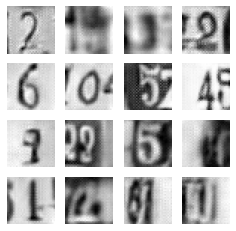

Time for epoch 101 is 36.817681550979614 sec, generation loss: -65.43208312988281, discrimination loss: 57.55596923828125
Time for epoch 102 is 35.57875633239746 sec, generation loss: -57.18727493286133, discrimination loss: -0.05442795529961586
Time for epoch 103 is 35.5017454624176 sec, generation loss: -66.2560043334961, discrimination loss: 50.861419677734375
Time for epoch 104 is 35.53917741775513 sec, generation loss: -71.97679901123047, discrimination loss: 44.254119873046875
Time for epoch 105 is 35.57107353210449 sec, generation loss: -70.17726135253906, discrimination loss: 55.09599685668945
Time for epoch 106 is 35.65773391723633 sec, generation loss: -68.07647705078125, discrimination loss: 48.122100830078125
Time for epoch 107 is 35.672295808792114 sec, generation loss: -64.69740295410156, discrimination loss: 40.32154846191406
Time for epoch 108 is 35.677637815475464 sec, generation loss: -71.96324157714844, discrimination loss: 63.40728759765625
Time for epoch 109 is 35.

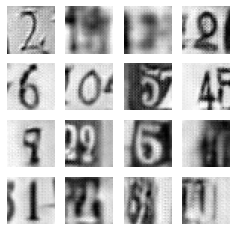

Time for epoch 111 is 36.639350175857544 sec, generation loss: -66.5466079711914, discrimination loss: 29.40191650390625
Time for epoch 112 is 35.630451679229736 sec, generation loss: -63.201446533203125, discrimination loss: 30.79779624938965
Time for epoch 113 is 35.646100997924805 sec, generation loss: -68.7004165649414, discrimination loss: 50.01972961425781
Time for epoch 114 is 35.6090087890625 sec, generation loss: -63.19874572753906, discrimination loss: 24.303003311157227
Time for epoch 115 is 35.49927377700806 sec, generation loss: -73.62553405761719, discrimination loss: 84.99383544921875
Time for epoch 116 is 35.4638466835022 sec, generation loss: -71.52798461914062, discrimination loss: 44.31012725830078
Time for epoch 117 is 35.43859028816223 sec, generation loss: -70.7970199584961, discrimination loss: 54.355262756347656
Time for epoch 118 is 35.54245185852051 sec, generation loss: -69.17533874511719, discrimination loss: 71.20476531982422
Time for epoch 119 is 35.569671

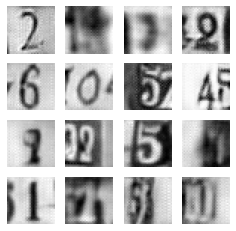

Time for epoch 121 is 36.578566789627075 sec, generation loss: -71.78545379638672, discrimination loss: 31.72282600402832
Time for epoch 122 is 35.67989897727966 sec, generation loss: -60.55719757080078, discrimination loss: 50.795806884765625
Time for epoch 123 is 35.67389988899231 sec, generation loss: -71.50625610351562, discrimination loss: 25.13494300842285
Time for epoch 124 is 35.65265393257141 sec, generation loss: -63.24425506591797, discrimination loss: 19.403942108154297
Time for epoch 125 is 35.58542585372925 sec, generation loss: -57.18909454345703, discrimination loss: 28.176305770874023
Time for epoch 126 is 35.538750886917114 sec, generation loss: -60.6334342956543, discrimination loss: 133.25677490234375
Time for epoch 127 is 35.610936403274536 sec, generation loss: -70.84095001220703, discrimination loss: 30.380096435546875
Time for epoch 128 is 35.74503755569458 sec, generation loss: -61.393531799316406, discrimination loss: 43.462162017822266
Time for epoch 129 is 3

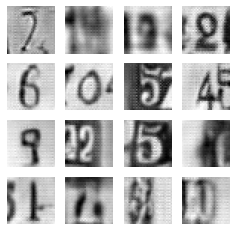

Time for epoch 131 is 36.603508949279785 sec, generation loss: -66.5671157836914, discrimination loss: 59.47328567504883
Time for epoch 132 is 35.64862060546875 sec, generation loss: -66.5322265625, discrimination loss: 41.701358795166016
Time for epoch 133 is 35.55718469619751 sec, generation loss: -63.98448944091797, discrimination loss: 67.75415802001953
Time for epoch 134 is 35.59274888038635 sec, generation loss: -67.15008544921875, discrimination loss: 96.21550750732422
Time for epoch 135 is 35.52057123184204 sec, generation loss: -67.76751708984375, discrimination loss: 44.59077835083008
Time for epoch 136 is 35.5688271522522 sec, generation loss: -68.93639373779297, discrimination loss: -28.6959228515625
Time for epoch 137 is 35.61846089363098 sec, generation loss: -64.87698364257812, discrimination loss: 12.719843864440918
Time for epoch 138 is 35.61060953140259 sec, generation loss: -52.302242279052734, discrimination loss: 67.98330688476562
Time for epoch 139 is 35.628609180

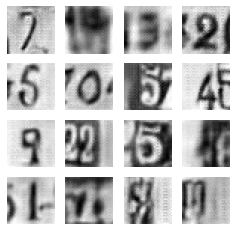

Time for epoch 141 is 36.71877455711365 sec, generation loss: -26.53907012939453, discrimination loss: -124.58773040771484
Time for epoch 142 is 35.65904688835144 sec, generation loss: -8.044119834899902, discrimination loss: -33.10448455810547
Time for epoch 143 is 35.63308072090149 sec, generation loss: -5.27969217300415, discrimination loss: 16.2156982421875
Time for epoch 144 is 35.65236020088196 sec, generation loss: -3.0548999309539795, discrimination loss: 172.3663787841797
Time for epoch 145 is 35.67712950706482 sec, generation loss: -3.955202579498291, discrimination loss: 50.31572341918945
Time for epoch 146 is 35.587690114974976 sec, generation loss: -5.501111030578613, discrimination loss: 160.91249084472656
Time for epoch 147 is 35.63557553291321 sec, generation loss: -5.790806770324707, discrimination loss: -17.12940216064453
Time for epoch 148 is 35.556416034698486 sec, generation loss: -3.844322681427002, discrimination loss: 188.58444213867188
Time for epoch 149 is 35.

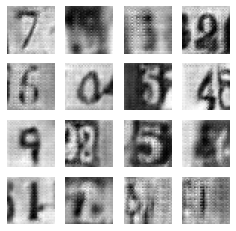

Time for epoch 151 is 36.78214240074158 sec, generation loss: -4.7108917236328125, discrimination loss: 147.0789794921875
Time for epoch 152 is 35.59959411621094 sec, generation loss: -10.984424591064453, discrimination loss: -39.801021575927734
Time for epoch 153 is 35.588385820388794 sec, generation loss: -1.7400078773498535, discrimination loss: 151.8675994873047
Time for epoch 154 is 35.669642210006714 sec, generation loss: -6.9047441482543945, discrimination loss: -37.21217727661133
Time for epoch 155 is 35.69704294204712 sec, generation loss: -6.235232830047607, discrimination loss: -85.6269760131836
Time for epoch 156 is 35.68528413772583 sec, generation loss: -5.776736259460449, discrimination loss: 82.55506896972656
Time for epoch 157 is 35.674177169799805 sec, generation loss: -4.251511096954346, discrimination loss: 78.82001495361328
Time for epoch 158 is 35.665283203125 sec, generation loss: -7.607650279998779, discrimination loss: 157.16897583007812
Time for epoch 159 is 3

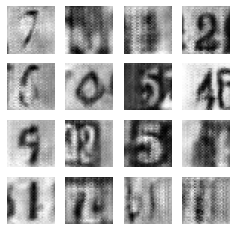

Time for epoch 161 is 36.66251564025879 sec, generation loss: -6.836218357086182, discrimination loss: 19.804336547851562
Time for epoch 162 is 35.612414598464966 sec, generation loss: -6.27871036529541, discrimination loss: 121.47359466552734
Time for epoch 163 is 35.57108163833618 sec, generation loss: -7.076766490936279, discrimination loss: -37.46391296386719
Time for epoch 164 is 35.56773328781128 sec, generation loss: -8.167827606201172, discrimination loss: 156.77816772460938
Time for epoch 165 is 35.56709051132202 sec, generation loss: -10.732322692871094, discrimination loss: 254.40335083007812
Time for epoch 166 is 35.58060431480408 sec, generation loss: -13.711319923400879, discrimination loss: 73.2206039428711
Time for epoch 167 is 35.53088331222534 sec, generation loss: -9.5228910446167, discrimination loss: -65.34162139892578
Time for epoch 168 is 35.65070700645447 sec, generation loss: -8.109522819519043, discrimination loss: 17.753995895385742
Time for epoch 169 is 35.6

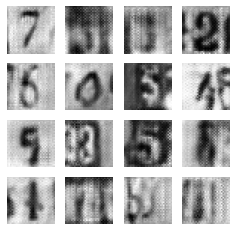

Time for epoch 171 is 36.513049364089966 sec, generation loss: -12.306571006774902, discrimination loss: 91.94076538085938
Time for epoch 172 is 35.479761838912964 sec, generation loss: -14.021843910217285, discrimination loss: 1.6822091341018677
Time for epoch 173 is 35.532692193984985 sec, generation loss: -9.667093276977539, discrimination loss: 199.10198974609375
Time for epoch 174 is 35.59761357307434 sec, generation loss: -13.463250160217285, discrimination loss: 53.12545394897461
Time for epoch 175 is 35.54206562042236 sec, generation loss: -7.509572982788086, discrimination loss: -34.54403305053711
Time for epoch 176 is 35.51255440711975 sec, generation loss: -12.034683227539062, discrimination loss: 131.74237060546875
Time for epoch 177 is 35.47461819648743 sec, generation loss: -17.652658462524414, discrimination loss: 55.39170837402344
Time for epoch 178 is 35.53220009803772 sec, generation loss: -18.561260223388672, discrimination loss: 189.7008514404297
Time for epoch 179 

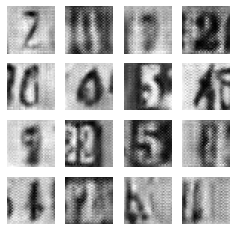

Time for epoch 181 is 36.838064193725586 sec, generation loss: -37.12150955200195, discrimination loss: 50.20262908935547
Time for epoch 182 is 35.534860134124756 sec, generation loss: -32.01637268066406, discrimination loss: 252.60267639160156
Time for epoch 183 is 35.592581272125244 sec, generation loss: -57.19364547729492, discrimination loss: 212.9106903076172
Time for epoch 184 is 35.59569811820984 sec, generation loss: -25.29070472717285, discrimination loss: 88.3268814086914
Time for epoch 185 is 35.563307762145996 sec, generation loss: -16.977890014648438, discrimination loss: -38.158447265625
Time for epoch 186 is 35.512702226638794 sec, generation loss: -13.70153522491455, discrimination loss: 48.75924301147461
Time for epoch 187 is 35.61587357521057 sec, generation loss: -13.671018600463867, discrimination loss: 51.5864372253418
Time for epoch 188 is 35.52126669883728 sec, generation loss: -35.769771575927734, discrimination loss: -30.189044952392578
Time for epoch 189 is 35

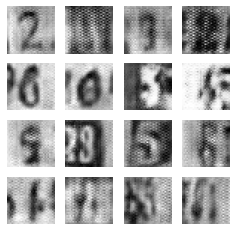

Time for epoch 191 is 36.808011531829834 sec, generation loss: -41.19518280029297, discrimination loss: 292.1324462890625
Time for epoch 192 is 35.62285542488098 sec, generation loss: -47.782814025878906, discrimination loss: 413.87109375
Time for epoch 193 is 35.590614557266235 sec, generation loss: -15.666406631469727, discrimination loss: 24.147476196289062
Time for epoch 194 is 35.62619590759277 sec, generation loss: -10.732823371887207, discrimination loss: -185.2859344482422
Time for epoch 195 is 35.63029074668884 sec, generation loss: -13.221887588500977, discrimination loss: 64.59638977050781
Time for epoch 196 is 35.54917526245117 sec, generation loss: -28.832908630371094, discrimination loss: 231.01132202148438
Time for epoch 197 is 35.625980854034424 sec, generation loss: -26.527536392211914, discrimination loss: 142.66212463378906
Time for epoch 198 is 35.581029415130615 sec, generation loss: -22.31946563720703, discrimination loss: 94.58833312988281
Time for epoch 199 is 3

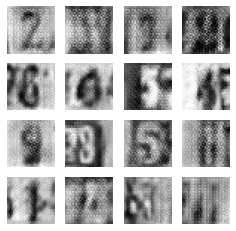

In [32]:
gen_log_dir = 'logs/gradient_tape/GAN_gen_2'
disc_log_dir = 'logs/gradient_tape/GAN_disc_2'
gen_summary_writer = summary_writer(gen_log_dir)
disc_summary_writer = summary_writer(disc_log_dir)
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
model_='model_30_w'
train(train_x, 200, generator_2, discriminator_2)



In [33]:
generator_2.save('/content/drive/MyDrive/AML - john & samory/'+model_+'.h5')
train_loss.to_csv('/content/drive/MyDrive/AML - john & samory/'+model_+'.csv')

In [ ]:
%tensorboard --logdir {'/content/logs/gradient_tape'}

In [ ]:
%tensorboard --logdir {disc_log_dir}

In [ ]:
%tensorboard --logdir {'/content/logs/gradient_tape'}